# Bad Initialization Robustness Test - CartPole Environment

This notebook analyzes the robustness of adaptive reward functions in the CartPole environment. We start with a deliberately poor reward function and measure how the system adapts through updates.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
import os
import sys
import inspect
from pathlib import Path
from datetime import datetime
from difflib import Differ

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Set paths
current_dir = os.getcwd()
project_root = str(Path(current_dir).parent.parent)
sys.path.append(project_root)

# Import required modules from the existing codebase
from AdaptiveRewardFunctionLearning.Prompts.prompts import device, apiKey, modelName
from RLEnvironment.env import CustomCartPoleEnv
from AdaptiveRewardFunctionLearning.RewardGeneration.rewardCritic import RewardUpdateSystem
from RLEnvironment.training.agent import DQLearningAgent
from RLEnvironment.training.training import trainDQLearning
from AdaptiveRewardFunctionLearning.Visualisation.trainingTestFunctions import (
    runEpisode,
    detectJumps,
    analyzeRewardSensibility,
    performUpdate,
    savePlot
)

# Helper function to save plots
def save_plot(fig, name, folder="RobustnessResults"):
    # Create logs directory with subfolder if it doesn't exist
    logs_dir = Path(project_root) / 'AdaptiveRewardFunctionLearning' / 'Experiments' / folder
    if not os.path.exists(logs_dir):
        os.makedirs(logs_dir)
    
    # Create timestamp
    timestamp = datetime.now().strftime("%d%m%Y_%H%M%S")
    
    # Full path for saving
    filepath = os.path.join(logs_dir, f"{name}_{timestamp}.png")
    
    # Save figure
    fig.savefig(filepath, bbox_inches='tight', dpi=300)
    print(f"Saved plot: {name}_{timestamp}.png in {folder}")

## Define Bad Initial Reward Function

We start with a deliberately poor reward function that will be improved through adaptive updates.

In [2]:
# Set bad initial reward function - punishes position control and gives minimal reward for angle stability
def badReward(observation, action):
    x, xDot, angle, angleDot = observation
    return float(-5.0 * abs(x) + 0.1 * np.cos(angle) - 0.1 * abs(xDot))

# Test the bad reward function with various cart-pole states to see how it behaves
test_states = [
    [0, 0, 0, 0],  # Perfectly centered and balanced
    [1.0, 0, 0, 0],  # Off-center but balanced
    [0, 0, 0.1, 0],  # Centered but slight angle
    [0, 1.0, 0, 0],  # Moving but balanced
    [0, 0, 0, 1.0],  # Pole is rotating
    [1.0, 1.0, 0.1, 0.1]  # Off-center, moving, slight angle and rotation
]

print("Testing bad reward function:")
for i, state in enumerate(test_states):
    reward = badReward(state, 0)
    state_desc = [
        "Perfectly centered and balanced",
        "Off-center but balanced",
        "Centered but slight angle",
        "Moving but balanced",
        "Pole is rotating",
        "Off-center, moving, slight angle and rotation"
    ]
    print(f"State {i+1} ({state_desc[i]}): Reward = {reward:.4f}")

# Explain why this is a bad reward function
print("\nWhy this is a poor reward function:")
print("1. It heavily punishes the cart being away from center (-5.0 * abs(x))")
print("2. It barely rewards pole balance (0.1 * cos(angle))")
print("3. It punishes cart movement, which is needed to balance the pole")
print("4. The overall balance of rewards is wrong for effective learning")

Testing bad reward function:
State 1 (Perfectly centered and balanced): Reward = 0.1000
State 2 (Off-center but balanced): Reward = -4.9000
State 3 (Centered but slight angle): Reward = 0.0995
State 4 (Moving but balanced): Reward = 0.0000
State 5 (Pole is rotating): Reward = 0.1000
State 6 (Off-center, moving, slight angle and rotation): Reward = -5.0005

Why this is a poor reward function:
1. It heavily punishes the cart being away from center (-5.0 * abs(x))
2. It barely rewards pole balance (0.1 * cos(angle))
3. It punishes cart movement, which is needed to balance the pole
4. The overall balance of rewards is wrong for effective learning


## Run the Bad Initialization Experiment

This experiment starts with a deliberately bad reward function and uses the adaptive update system to improve it.

In [3]:
def runBadInitializationTest(episodes=500, update_interval=100):
    """Run a robustness test starting with a bad reward function"""
    print("Starting Bad Initialization Test...")
    
    # Set up environment with bad reward function
    env = gym.make('CartPole-v1')
    env = CustomCartPoleEnv(env)
    env.setRewardFunction(badReward)

    # Set up update system and agent
    updateSystem = RewardUpdateSystem(apiKey, modelName)
    agent = DQLearningAgent(env, 4, 2, device)
    
    # Initialize tracking variables
    rewards = []
    balance_times = [] 
    metrics = {}
    reward_change_episodes = []
    update_history = []
    reward_functions = []
    
    # Store initial reward function
    reward_functions.append({
        'episode': 0,
        'function': env.rewardFunction.__name__,
        'code': inspect.getsource(env.rewardFunction)
    })
    
    for episode in range(episodes):
        # Run one episode
        state = env.reset()[0]
        episode_reward = 0
        timesteps = 0 
        done = False

        while not done:
            action = agent.chooseAction(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            timesteps += 1 
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            
            # Train the agent
            if len(agent.memory) > agent.batchSize:
                agent.replay(agent.batchSize)

        # Record episode results
        rewards.append(episode_reward)
        balance_times.append(timesteps)
        
        # Calculate metrics periodically
        if episode % 50 == 0 or episode == episodes - 1:
            metrics[episode] = {
                'jumps': detectJumps(rewards[-100:] if len(rewards) >= 100 else rewards),
                'averageReward': np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards),
                'sensibility': analyzeRewardSensibility(env.rewardFunction) if callable(env.rewardFunction) else {'mean': 0, 'std': 0},
                'averageBalanceTime': np.mean(balance_times[-100:]) if len(balance_times) >= 100 else np.mean(balance_times)
            }
            print(f"Episode {episode}: Avg Reward = {metrics[episode]['averageReward']:.2f}, Avg Balance Time = {metrics[episode]['averageBalanceTime']:.2f}")
            
        # Check if we should update the reward function
        if updateSystem.waitingTimeConstant(episode, update_interval):
            old_function = env.rewardFunction
            old_function_str = inspect.getsource(old_function) if callable(old_function) else str(old_function)
            
            # Perform the update
            print(f"\nAttempting update at episode {episode}")
            if performUpdate(env, updateSystem, episode):  # Check if update happened
                # Ensure reward function is callable
                if isinstance(env.rewardFunction, str):
                    # Convert string to function
                    local_namespace = {}
                    try:
                        exec(env.rewardFunction, globals(), local_namespace)
                        new_function = None
                        for item in local_namespace.values():
                            if callable(item):
                                new_function = item
                                break
                        if new_function:
                            env.setRewardFunction(new_function)
                        else:
                            print("Warning: Could not extract function from string")
                    except Exception as e:
                        print(f"Error converting string to function: {e}")
                
                reward_change_episodes.append(episode)
                
                # Store the new function
                if callable(env.rewardFunction):
                    try:
                        function_code = inspect.getsource(env.rewardFunction)
                    except Exception:
                        function_code = str(env.rewardFunction)
                else:
                    function_code = str(env.rewardFunction)

                reward_functions.append({
                    'episode': episode,
                    'function': getattr(env.rewardFunction, '__name__', 'unnamed_function'),
                    'code': function_code
                })
                
                # Record update history with proper error handling for mean calculations
                pre_update_rewards = rewards[max(0, episode-update_interval):episode]
                pre_update_balance = balance_times[max(0, episode-update_interval):episode]
                
                update_history.append({
                    'episode': episode,
                    'old_function': old_function_str,
                    'new_function': function_code,
                    'pre_update_avg_reward': np.mean(pre_update_rewards) if len(pre_update_rewards) > 0 else 0,
                    'pre_update_avg_balance': np.mean(pre_update_balance) if len(pre_update_balance) > 0 else 0
                })
                print("Reward function updated")
    
    # Return all experiment data
    print(f"\nExperiment completed with {len(reward_change_episodes)} updates")
    return {
        'rewards': rewards,
        'balance_times': balance_times, 
        'metrics': metrics,
        'update_episodes': reward_change_episodes,
        'update_history': update_history,
        'reward_functions': reward_functions
    }



# Run the experiment
experiment_data = runBadInitializationTest(episodes=10000, update_interval=2000)

Starting Bad Initialization Test...
Episode 0: Avg Reward = 27.87, Avg Balance Time = 28.00


/home/sd37/BachelorsThesis/Using-LLMs-to-Generate-Reward-Functions-from-Natural-Language-in-RL-Environments/RLEnvironment/training/agent.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor([t[0] for t in minibatch], dtype=torch.float32).to(self.device)


Episode 50: Avg Reward = 19.70, Avg Balance Time = 19.80
Episode 100: Avg Reward = 17.89, Avg Balance Time = 18.00
Episode 150: Avg Reward = 16.07, Avg Balance Time = 16.18
Episode 200: Avg Reward = 15.49, Avg Balance Time = 15.60
Episode 250: Avg Reward = 15.12, Avg Balance Time = 15.23
Episode 300: Avg Reward = 15.48, Avg Balance Time = 15.59
Episode 350: Avg Reward = 15.46, Avg Balance Time = 15.58
Episode 400: Avg Reward = 15.17, Avg Balance Time = 15.28
Episode 450: Avg Reward = 15.24, Avg Balance Time = 15.35
Episode 500: Avg Reward = 15.09, Avg Balance Time = 15.20
Episode 550: Avg Reward = 15.29, Avg Balance Time = 15.40
Episode 600: Avg Reward = 15.56, Avg Balance Time = 15.68
Episode 650: Avg Reward = 15.36, Avg Balance Time = 15.48
Episode 700: Avg Reward = 15.09, Avg Balance Time = 15.20
Episode 750: Avg Reward = 15.05, Avg Balance Time = 15.16
Episode 800: Avg Reward = 15.33, Avg Balance Time = 15.45
Episode 850: Avg Reward = 15.46, Avg Balance Time = 15.58
Episode 900: Av

/home/sd37/.conda/envs/thesis/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sd37/.conda/envs/thesis/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Reward function updated
Error converting string to function: unmatched ')' (<string>, line 1)
Reward function updated
Episode 2050: Avg Reward = 18.10, Avg Balance Time = 18.21
Episode 2100: Avg Reward = 19.38, Avg Balance Time = 19.50
Episode 2150: Avg Reward = 19.79, Avg Balance Time = 19.91
Episode 2200: Avg Reward = 20.61, Avg Balance Time = 20.73
Episode 2250: Avg Reward = 19.18, Avg Balance Time = 19.28
Episode 2300: Avg Reward = 17.84, Avg Balance Time = 17.92
Episode 2350: Avg Reward = 18.82, Avg Balance Time = 18.90
Episode 2400: Avg Reward = 19.11, Avg Balance Time = 19.19
Episode 2450: Avg Reward = 18.57, Avg Balance Time = 18.65
Episode 2500: Avg Reward = 19.15, Avg Balance Time = 19.22
Episode 2550: Avg Reward = 22.81, Avg Balance Time = 22.88
Episode 2600: Avg Reward = 24.83, Avg Balance Time = 24.90
Episode 2650: Avg Reward = 26.24, Avg Balance Time = 26.31
Episode 2700: Avg Reward = 28.61, Avg Balance Time = 28.69
Episode 2750: Avg Reward = 30.96, Avg Balance Time = 31.

## Analyze Reward Function Evolution

Let's examine how the reward function evolved over the course of the experiment.

In [4]:
def analyze_reward_functions(reward_functions):
    """Analyze the evolution of reward functions over time"""
    
    # Print all reward functions
    for i, func_data in enumerate(reward_functions):
        print(f"\nReward Function {i+1} (Episode {func_data['episode']}):\n")
        print(func_data['code'])
    
    # Compare consecutive reward functions
    print("\n\nDifferences Between Consecutive Reward Functions:")
    
    for i in range(1, len(reward_functions)):
        prev_code = reward_functions[i-1]['code']
        curr_code = reward_functions[i]['code']
        
        differ = Differ()
        diff = list(differ.compare(prev_code.splitlines(), curr_code.splitlines()))
        
        print(f"\n\nChanges from Function {i} (Episode {reward_functions[i-1]['episode']}) to {i+1} (Episode {reward_functions[i]['episode']}):")
        for line in diff:
            if line.startswith('+ ') or line.startswith('- ') or line.startswith('? '):
                print(line)

# Analyze reward functions if there were any updates
if 'reward_functions' in experiment_data and len(experiment_data['reward_functions']) > 1:
    analyze_reward_functions(experiment_data['reward_functions'])


Reward Function 1 (Episode 0):

def badReward(observation, action):
    x, xDot, angle, angleDot = observation
    return float(-5.0 * abs(x) + 0.1 * np.cos(angle) - 0.1 * abs(xDot))


Reward Function 2 (Episode 2000):

def rewardFunctionobservation, action):
    # Extract relevant state variables from observation
    cart_position = observation[0]
    pole_angle = observation[2]
    
    # Primary reward component: Pole angle stability (highest positive weight)
    angle_stability_reward = 2.0 * (1 - abs(pole_angle))  # Weight: 2.0, increases as angle approaches 0
    
    # Secondary penalty: Cart position (smaller negative weight)
    position_penalty = -0.2 * abs(cart_position)  # Weight: -0.2, increases as cart moves from center

    # Calculate total reward
    total_reward = angle_stability_reward + position_penalty

    # Ensure the reward is positive when the pole is upright, even if the cart is off-center
    total_reward = max(total_reward, 0.1)  # Minimum reward of 0.1 to 

## Performance Visualization

Let's create a detailed visualization showing how rewards and balance times changed over episodes.

Saved plot: adaptive_performance_bad_init_29032025_123319.png in RobustnessResults


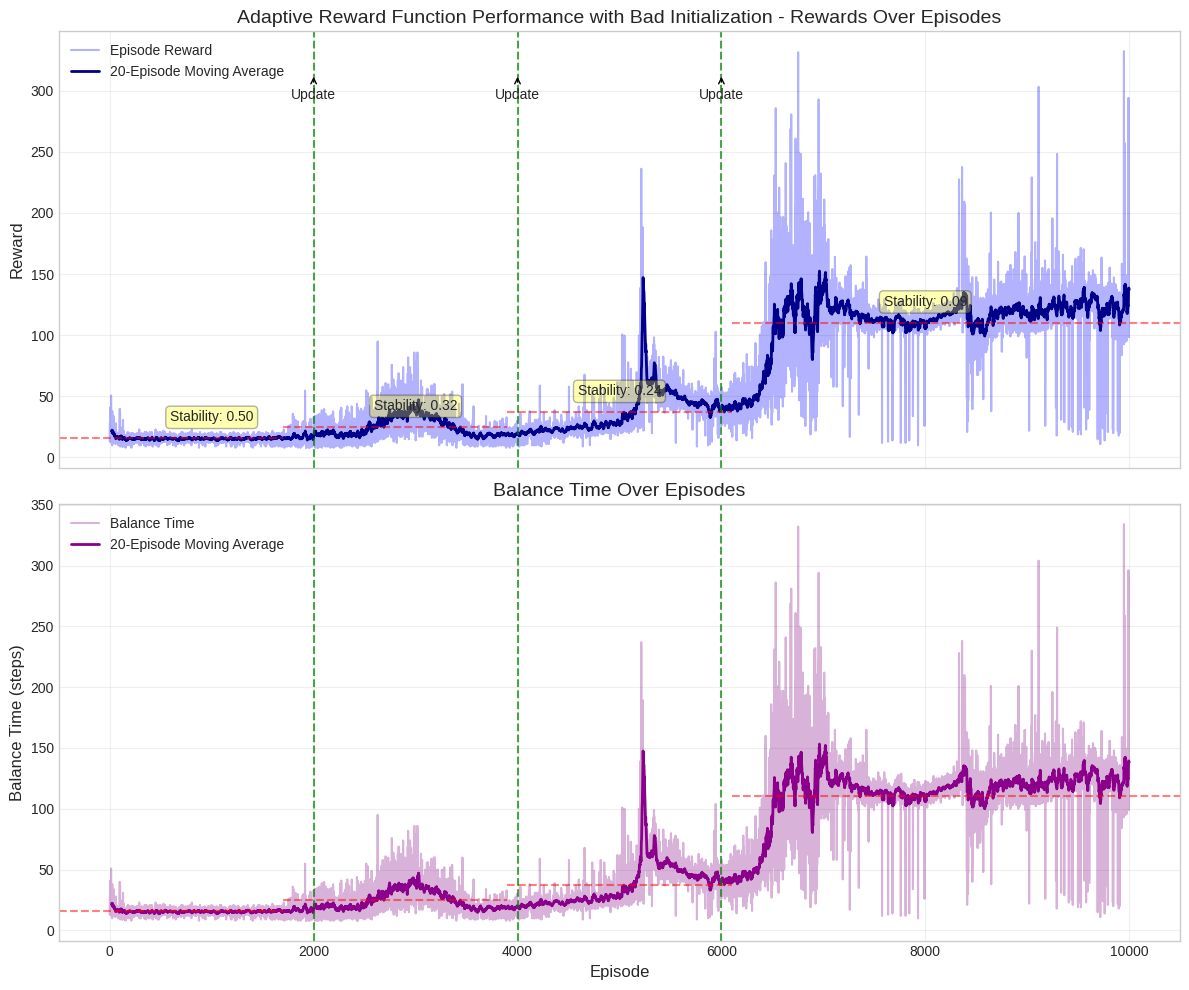

In [5]:
def create_performance_visualization(exp_data, title="Adaptive Reward Function Performance"):
    """Create a comprehensive performance visualization with rewards and balance times"""
    
    # Extract data
    rewards = exp_data['rewards']
    balance_times = exp_data['balance_times']
    update_episodes = exp_data['update_episodes']
    
    # Calculate moving averages
    window_size = 20
    rewards_ma = pd.Series(rewards).rolling(window_size).mean()
    balance_ma = pd.Series(balance_times).rolling(window_size).mean()
    
    # Calculate metrics for segments between updates
    segments = []
    start_episode = 0
    
    for update_ep in update_episodes + [len(rewards)]:
        segment_rewards = rewards[start_episode:update_ep]
        segment_balance = balance_times[start_episode:update_ep]
        
        if len(segment_rewards) > 10:  # Only calculate if we have enough data
            segments.append({
                'start': start_episode,
                'end': update_ep,
                'avg_reward': np.mean(segment_rewards),
                'avg_balance': np.mean(segment_balance),
                'min_reward': np.min(segment_rewards),
                'max_reward': np.max(segment_rewards),
                'stability': np.min(segment_rewards) / np.mean(segment_rewards) if np.mean(segment_rewards) > 0 else 0
            })
        
        start_episode = update_ep
    
    # Create a subplot figure with rewards and balance times
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot rewards
    ax1.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
    ax1.plot(rewards_ma, linewidth=2, color='darkblue', label=f'{window_size}-Episode Moving Average')
    
    # Add horizontal lines for segment averages
    for segment in segments:
        ax1.axhline(y=segment['avg_reward'], 
                  xmin=segment['start']/len(rewards), 
                  xmax=segment['end']/len(rewards),
                  color='red', linestyle='--', alpha=0.5)
        
        # Annotate stability score
        ax1.annotate(f"Stability: {segment['stability']:.2f}", 
                   xy=((segment['start'] + segment['end'])/2, segment['avg_reward']),
                   xytext=(0, 10), textcoords='offset points',
                   ha='center', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3))
    
    # Add vertical lines for updates
    for episode in update_episodes:
        ax1.axvline(x=episode, color='green', linestyle='--', alpha=0.7)
        ax1.annotate(f"Update", xy=(episode, ax1.get_ylim()[1]*0.9),
                    xytext=(0, -20), textcoords='offset points',
                    ha='center', va='bottom',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    ax1.set_title(f"{title} - Rewards Over Episodes", fontsize=14)
    ax1.set_ylabel("Reward", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # Plot balance times
    ax2.plot(balance_times, alpha=0.3, color='purple', label='Balance Time')
    ax2.plot(balance_ma, linewidth=2, color='darkmagenta', label=f'{window_size}-Episode Moving Average')
    
    # Add horizontal lines for segment averages
    for segment in segments:
        ax2.axhline(y=segment['avg_balance'], 
                  xmin=segment['start']/len(balance_times), 
                  xmax=segment['end']/len(balance_times),
                  color='red', linestyle='--', alpha=0.5)
    
    # Add vertical lines for updates
    for episode in update_episodes:
        ax2.axvline(x=episode, color='green', linestyle='--', alpha=0.7)
    
    ax2.set_title("Balance Time Over Episodes", fontsize=14)
    ax2.set_xlabel("Episode", fontsize=12)
    ax2.set_ylabel("Balance Time (steps)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    return fig

# Create and display performance visualization
performance_fig = create_performance_visualization(experiment_data, "Adaptive Reward Function Performance with Bad Initialization")
save_plot(performance_fig, "adaptive_performance_bad_init")
plt.show()

## Calculate and Plot Robustness Metrics

Let's compute various robustness metrics to quantify the system's ability to recover from a poor initial reward function.

Saved plot: robustness_metrics_29032025_123320.png in RobustnessResults


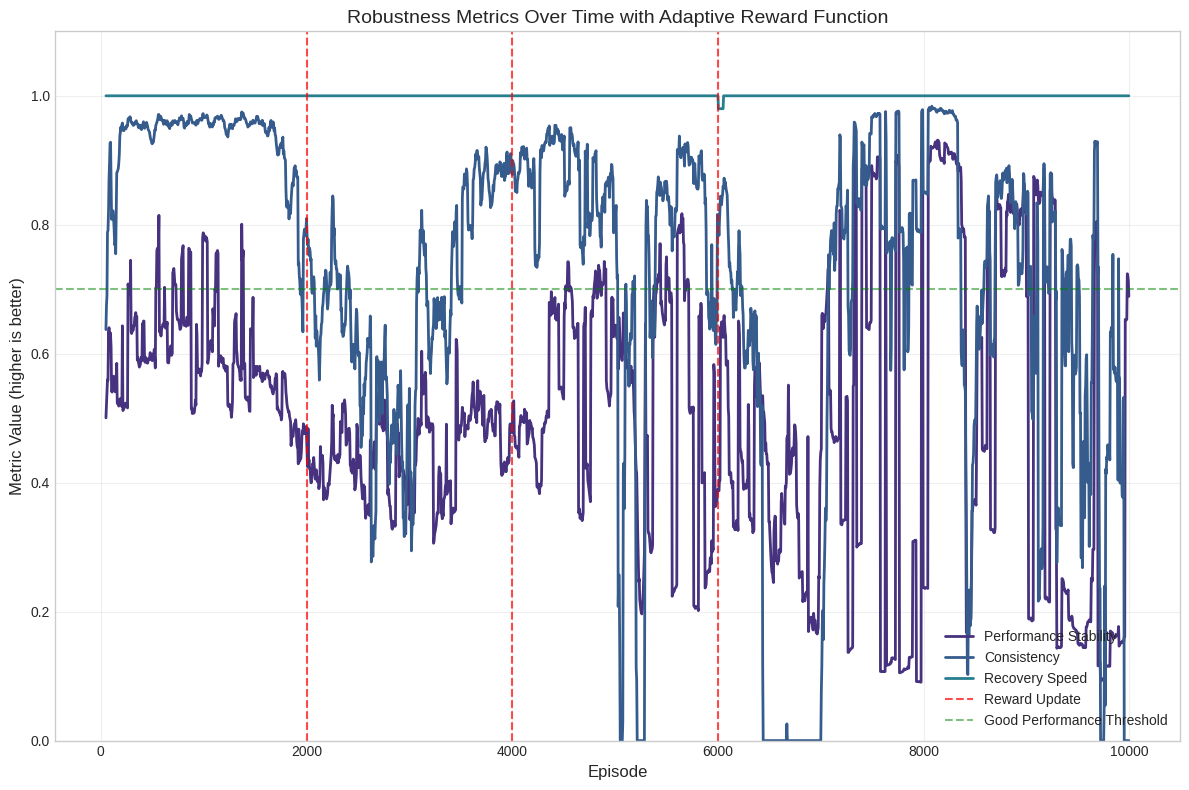

In [6]:
def calculate_robustness_metrics(exp_data, window_size=50):
    """Calculate robustness metrics over sliding windows"""
    rewards = exp_data['rewards']
    balance_times = exp_data['balance_times']
    update_episodes = exp_data['update_episodes']
    
    # Calculate metrics in sliding windows
    metrics = []
    
    for i in range(window_size, len(rewards), 5):  # Step by 5 episodes to reduce data points
        window_rewards = rewards[i-window_size:i]
        window_balance = balance_times[i-window_size:i]
        
        # Performance stability: ratio of min to average performance
        # Higher values (closer to 1) indicate more stable performance
        performance_stability = np.min(window_rewards) / np.mean(window_rewards) if np.mean(window_rewards) > 0 else 0
        
        # Variance: measure of consistency (normalized by mean to make it comparable)
        # Lower values indicate more consistent performance
        reward_variance = np.var(window_rewards) / (np.mean(window_rewards) if np.mean(window_rewards) > 0 else 1)
        reward_variance_normalized = min(1.0, reward_variance / 10)  # Cap at 1.0 for visualization
        
        # Check if there was an update in this window
        update_in_window = any(i-window_size <= ep < i for ep in update_episodes)
        
        # Calculate recovery speed if there was an update
        recovery_speed = 0
        if update_in_window:
            # Find the most recent update in this window
            update_ep = max([ep for ep in update_episodes if i-window_size <= ep < i])
            
            # Calculate how many episodes it took to recover
            pre_update_avg = np.mean(rewards[max(0, update_ep-window_size):update_ep])
            post_update_episodes = rewards[update_ep:i]
            
            # Find first episode that exceeds pre-update average
            recovery_episodes = np.where(np.array(post_update_episodes) >= pre_update_avg)[0]
            if len(recovery_episodes) > 0:
                recovery_speed = recovery_episodes[0] / window_size  # Normalize by window size
            else:
                recovery_speed = 1.0  # Maximum (worst) if didn't recover
        else:
            recovery_speed = 0.0  # No recovery needed if no update
        
        metrics.append({
            'episode': i,
            'performance_stability': performance_stability,
            'consistency': 1.0 - reward_variance_normalized,  # Invert so higher is better
            'recovery_speed': 1.0 - recovery_speed,  # Invert so higher is better
            'update_in_window': update_in_window,
            'avg_reward': np.mean(window_rewards),
            'avg_balance': np.mean(window_balance)
        })
    
    return pd.DataFrame(metrics)

# Calculate robustness metrics
metrics_df = calculate_robustness_metrics(experiment_data)

# Plot robustness metrics
def plot_robustness_metrics(metrics_df, update_episodes, title="Robustness Metrics Over Time"):
    """Plot robustness metrics over time"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot metrics
    ax.plot(metrics_df['episode'], metrics_df['performance_stability'], 
            label='Performance Stability', linewidth=2)
    ax.plot(metrics_df['episode'], metrics_df['consistency'], 
            label='Consistency', linewidth=2)
    ax.plot(metrics_df['episode'], metrics_df['recovery_speed'], 
            label='Recovery Speed', linewidth=2)
    
    # Add vertical lines for updates
    for episode in update_episodes:
        if episode >= metrics_df['episode'].min() and episode <= metrics_df['episode'].max():
            ax.axvline(x=episode, color='red', linestyle='--', alpha=0.7,
                     label='Reward Update' if episode == update_episodes[0] else '')
    
    # Add a 'good performance' threshold line
    ax.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, label='Good Performance Threshold')
    
    # Set labels and title
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Metric Value (higher is better)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    
    plt.tight_layout()
    return fig

# Plot metrics
metrics_fig = plot_robustness_metrics(metrics_df, experiment_data['update_episodes'], 
                                     "Robustness Metrics Over Time with Adaptive Reward Function")
save_plot(metrics_fig, "robustness_metrics")
plt.show()

## Analyze Segment Performance

Let's analyze performance in each segment between updates to quantify improvements.

Segment Performance Analysis:



,segment,start_episode,end_episode,avg_reward,avg_balance,stability
0,1,0,2000,15.739901,15.8550,0.504030
1,2,2000,4000,24.748547,24.8325,0.320682
2,3,4000,6000,36.955116,37.2055,0.241522
3,4,6000,10000,110.096664,110.7075,0.090024



Improvement Between Segments:



,segment,reward_improvement,balance_improvement,stability_improvement
0,1,0.000000,0.000000,0.000000
1,2,57.234455,56.622517,-36.376389
2,3,49.322365,49.825833,-24.685066
3,4,197.919937,197.556813,-62.726448


Saved plot: segment_improvement_29032025_123320.png in RobustnessResults


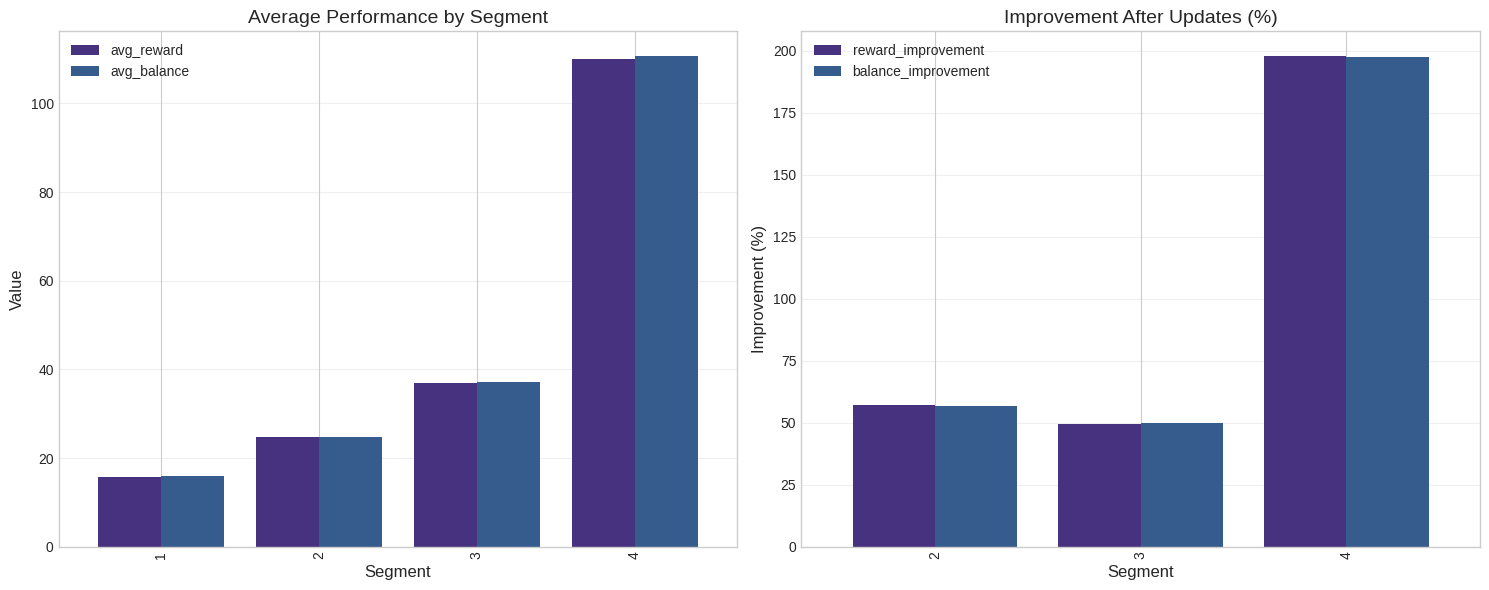

In [7]:
def analyze_segments(exp_data):
    """Analyze performance in segments between reward function updates"""
    rewards = exp_data['rewards']
    balance_times = exp_data['balance_times']
    update_episodes = exp_data['update_episodes']
    
    # Define segments
    segments = []
    prev_ep = 0
    
    for i, update_ep in enumerate(update_episodes + [len(rewards)]):
        segment_rewards = rewards[prev_ep:update_ep]
        segment_balance = balance_times[prev_ep:update_ep]
        
        segments.append({
            'segment': i + 1,
            'start_episode': prev_ep,
            'end_episode': update_ep,
            'length': update_ep - prev_ep,
            'avg_reward': np.mean(segment_rewards),
            'avg_balance': np.mean(segment_balance),
            'min_reward': np.min(segment_rewards),
            'max_reward': np.max(segment_rewards),
            'stability': np.min(segment_rewards) / np.mean(segment_rewards) if np.mean(segment_rewards) > 0 else 0,
            'variance': np.var(segment_rewards) / (np.mean(segment_rewards) if np.mean(segment_rewards) > 0 else 1)
        })
        
        prev_ep = update_ep
    
    # Create a DataFrame for analysis
    segments_df = pd.DataFrame(segments)
    
    # Calculate improvement between segments
    if len(segments_df) > 1:
        segments_df['reward_improvement'] = segments_df['avg_reward'].pct_change() * 100
        segments_df['balance_improvement'] = segments_df['avg_balance'].pct_change() * 100
        segments_df['stability_improvement'] = segments_df['stability'].pct_change() * 100
        
        # Fill NaN for first segment
        segments_df.loc[0, 'reward_improvement'] = 0
        segments_df.loc[0, 'balance_improvement'] = 0
        segments_df.loc[0, 'stability_improvement'] = 0
    
    # Display segment analysis
    print("Segment Performance Analysis:\n")
    display(segments_df[['segment', 'start_episode', 'end_episode', 'avg_reward', 
                       'avg_balance', 'stability']])
    
    if len(segments_df) > 1:
        print("\nImprovement Between Segments:\n")
        display(segments_df[['segment', 'reward_improvement', 'balance_improvement', 'stability_improvement']])
    
    # Create a bar chart showing improvement
    if len(segments_df) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot average metrics by segment
        segments_df.plot(x='segment', y=['avg_reward', 'avg_balance'], kind='bar', ax=ax1, width=0.8)
        ax1.set_title('Average Performance by Segment', fontsize=14)
        ax1.set_xlabel('Segment', fontsize=12)
        ax1.set_ylabel('Value', fontsize=12)
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Plot improvement percentages
        segments_df[1:].plot(x='segment', y=['reward_improvement', 'balance_improvement'], kind='bar', ax=ax2, width=0.8)
        ax2.set_title('Improvement After Updates (%)', fontsize=14)
        ax2.set_xlabel('Segment', fontsize=12)
        ax2.set_ylabel('Improvement (%)', fontsize=12)
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        save_plot(fig, "segment_improvement")
        plt.show()
    
    return segments_df

# Analyze segments
segments_df = analyze_segments(experiment_data)

## Analyze Update Impact

Let's analyze the immediate impact of each reward function update on performance.

Update Impact Analysis:



,update_number,episode,reward_change_pct,balance_change_pct,stability_change_pct
0,1,2000,31.569313,31.515152,-32.325008
1,2,4000,-12.601940,-12.561576,-6.187984
2,3,6000,4.027463,4.125000,3.677143


Saved plot: update_impact_29032025_123320.png in RobustnessResults


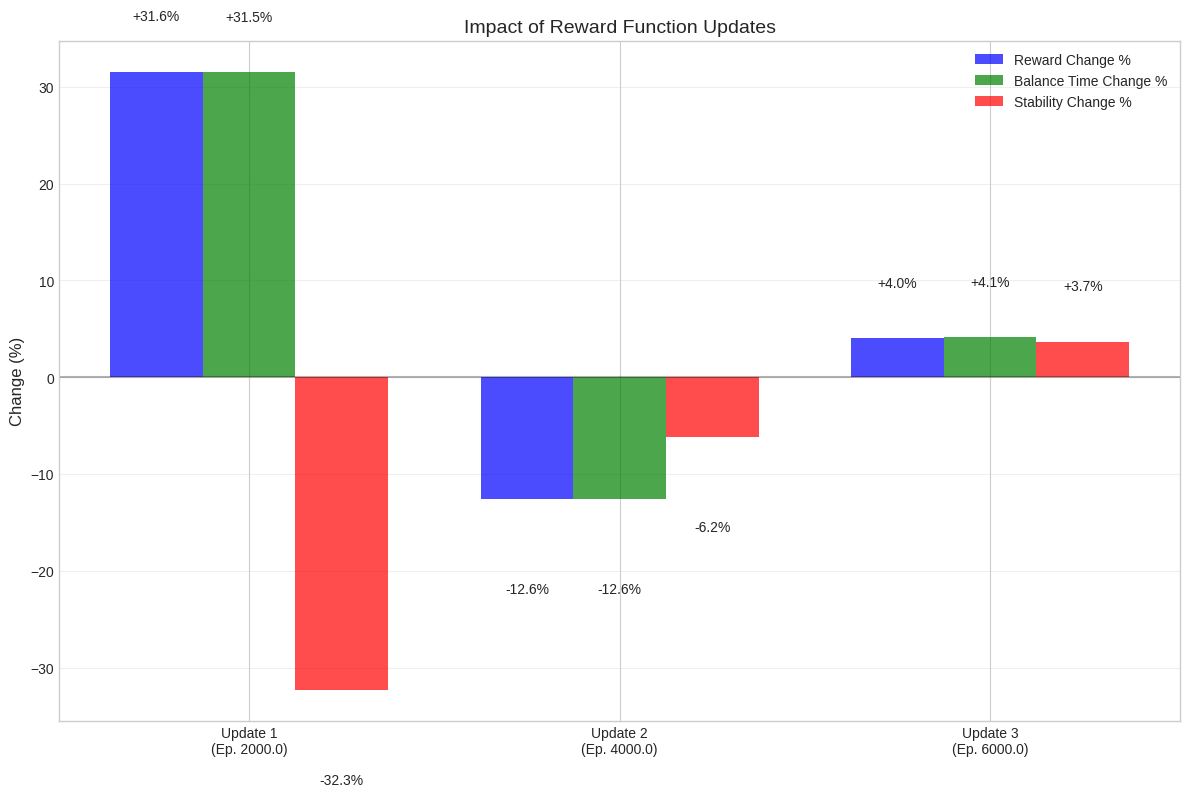

In [8]:
def analyze_update_impact(exp_data, window_size=20):
    """Analyze the impact of each update on performance"""
    rewards = exp_data['rewards']
    balance_times = exp_data['balance_times']
    update_episodes = exp_data['update_episodes']
    
    impact_data = []
    
    for i, update_ep in enumerate(update_episodes):
        if update_ep < window_size or update_ep + window_size >= len(rewards):
            continue  # Skip if we don't have enough data before/after
        
        # Calculate metrics before update
        pre_rewards = rewards[update_ep-window_size:update_ep]
        pre_balance = balance_times[update_ep-window_size:update_ep]
        
        # Calculate metrics after update
        post_rewards = rewards[update_ep:update_ep+window_size]
        post_balance = balance_times[update_ep:update_ep+window_size]
        
        # Calculate performance changes
        reward_change = np.mean(post_rewards) / np.mean(pre_rewards) if np.mean(pre_rewards) > 0 else float('inf')
        balance_change = np.mean(post_balance) / np.mean(pre_balance) if np.mean(pre_balance) > 0 else float('inf')
        reward_change_pct = (np.mean(post_rewards) - np.mean(pre_rewards)) / np.mean(pre_rewards) * 100 if np.mean(pre_rewards) > 0 else float('inf')
        balance_change_pct = (np.mean(post_balance) - np.mean(pre_balance)) / np.mean(pre_balance) * 100 if np.mean(pre_balance) > 0 else float('inf')
        
        # Calculate stability changes
        pre_stability = np.min(pre_rewards) / np.mean(pre_rewards) if np.mean(pre_rewards) > 0 else 0
        post_stability = np.min(post_rewards) / np.mean(post_rewards) if np.mean(post_rewards) > 0 else 0
        stability_change = post_stability / pre_stability if pre_stability > 0 else float('inf')
        stability_change_pct = (post_stability - pre_stability) / pre_stability * 100 if pre_stability > 0 else float('inf')
        
        impact_data.append({
            'update_number': i + 1,
            'episode': update_ep,
            'pre_avg_reward': np.mean(pre_rewards),
            'post_avg_reward': np.mean(post_rewards),
            'reward_change_ratio': reward_change,
            'reward_change_pct': reward_change_pct,
            'pre_avg_balance': np.mean(pre_balance),
            'post_avg_balance': np.mean(post_balance),
            'balance_change_ratio': balance_change,
            'balance_change_pct': balance_change_pct,
            'pre_stability': pre_stability,
            'post_stability': post_stability,
            'stability_change_ratio': stability_change,
            'stability_change_pct': stability_change_pct
        })
    
    # Create DataFrame for analysis
    impact_df = pd.DataFrame(impact_data)
    
    # Display impact analysis
    if len(impact_df) > 0:
        print("Update Impact Analysis:\n")
        display(impact_df[['update_number', 'episode', 'reward_change_pct', 'balance_change_pct', 'stability_change_pct']])
        
        # Create a bar chart showing impact
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot percentage changes
        index = np.arange(len(impact_df))
        bar_width = 0.25
        
        bars1 = ax.bar(index, impact_df['reward_change_pct'], bar_width,
                label='Reward Change %', color='blue', alpha=0.7)
        bars2 = ax.bar(index + bar_width, impact_df['balance_change_pct'], bar_width,
                label='Balance Time Change %', color='green', alpha=0.7)
        bars3 = ax.bar(index + 2*bar_width, impact_df['stability_change_pct'], bar_width,
                label='Stability Change %', color='red', alpha=0.7)
        
        # Add a reference line at 0%
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Set x-axis ticks and labels
        ax.set_xticks(index + bar_width)
        ax.set_xticklabels([f"Update {i}\n(Ep. {row['episode']})" for i, (_, row) in enumerate(impact_df.iterrows(), 1)])
        
        # Set labels and title
        ax.set_ylabel('Change (%)', fontsize=12)
        ax.set_title('Impact of Reward Function Updates', fontsize=14)
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend()
        
        # Add value labels above/below bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                          f'+{height:.1f}%', ha='center', va='bottom', rotation=0)
                elif height < 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height - 10,
                          f'{height:.1f}%', ha='center', va='bottom', rotation=0)
        
        plt.tight_layout()
        save_plot(fig, "update_impact")
        plt.show()
    else:
        print("No updates with sufficient data before/after to analyze impact.")
    
    return impact_df

# Analyze update impact
impact_df = analyze_update_impact(experiment_data)

## Calculate Overall Robustness Score

Let's compute a comprehensive robustness score based on all the metrics we've calculated.

Saved plot: robustness_scores_29032025_123321.png in RobustnessResults


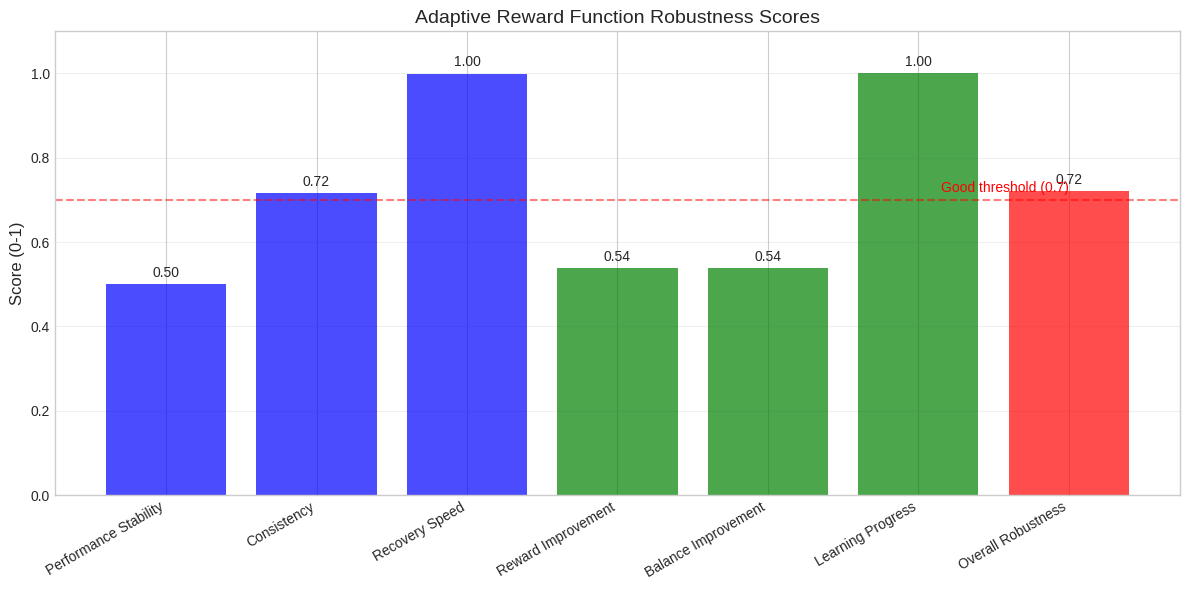


OVERALL ROBUSTNESS SCORE: 0.72
Good robustness. The adaptive reward function recovers well from the initial bad reward function with minor performance fluctuations during updates.


In [9]:
def calculate_robustness_score(metrics_df, impact_df, segments_df):
    """Calculate an overall robustness score based on multiple metrics"""
    
    scores = {}
    
    # 1. Performance Stability (from metrics_df)
    if len(metrics_df) > 0:
        scores['Performance Stability'] = metrics_df['performance_stability'].mean()
        scores['Consistency'] = metrics_df['consistency'].mean()
        scores['Recovery Speed'] = metrics_df['recovery_speed'].mean()
    else:
        scores['Performance Stability'] = 0
        scores['Consistency'] = 0
        scores['Recovery Speed'] = 0
    
    # 2. Update Impact (from impact_df)
    if len(impact_df) > 0:
        # Calculate average improvement (cap at 100% to avoid extreme values)
        avg_reward_improvement = impact_df['reward_change_pct'].clip(-100, 100).mean() / 100
        avg_balance_improvement = impact_df['balance_change_pct'].clip(-100, 100).mean() / 100
        
        # Normalize to [0, 1] range (0.5 means no change, 1 means 100% improvement, 0 means 100% worse)
        scores['Reward Improvement'] = 0.5 + avg_reward_improvement / 2
        scores['Balance Improvement'] = 0.5 + avg_balance_improvement / 2
    else:
        scores['Reward Improvement'] = 0.5  # Default to neutral if no impact data
        scores['Balance Improvement'] = 0.5
    
    # 3. Learning Progress (from segments_df)
    if len(segments_df) > 1:
        # Calculate overall improvement from first to last segment
        first_reward = segments_df.iloc[0]['avg_reward']
        last_reward = segments_df.iloc[-1]['avg_reward']
        reward_progress = (last_reward / first_reward) if first_reward > 0 else 0
        # Cap at 5x improvement and normalize to [0, 1]
        scores['Learning Progress'] = min(reward_progress / 5, 1.0)
    else:
        scores['Learning Progress'] = 0.5  # Default to neutral if not enough segments
    
    # Calculate weighted average for overall score
    weights = {
        'Performance Stability': 0.15,
        'Consistency': 0.15,
        'Recovery Speed': 0.15,
        'Reward Improvement': 0.2,
        'Balance Improvement': 0.15,
        'Learning Progress': 0.2
    }
    
    # Calculate overall score
    overall_score = sum(scores[metric] * weight for metric, weight in weights.items())
    scores['Overall Robustness'] = overall_score
    
    # Create a bar chart of scores
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Components to plot
    components = list(scores.keys())
    values = list(scores.values())
    
    # Choose colors based on component groups
    colors = ['blue', 'blue', 'blue', 'green', 'green', 'green', 'red']
    
    # Create bars
    bars = ax.bar(components, values, color=colors, alpha=0.7)
    
    # Add score values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')
    
    # Add a reference line at 0.7 (good threshold)
    ax.axhline(y=0.7, color='r', linestyle='--', alpha=0.5)
    ax.text(len(components)-1, 0.72, 'Good threshold (0.7)', color='r', ha='right')
    
    # Set plot attributes
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score (0-1)', fontsize=12)
    ax.set_title('Adaptive Reward Function Robustness Scores', fontsize=14)
    plt.xticks(rotation=30, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    save_plot(fig, "robustness_scores")
    plt.show()
    
    # Print interpretation
    if overall_score >= 0.8:
        interpretation = "Excellent robustness. The adaptive reward function maintains performance effectively through updates and shows significant improvement from the initial bad reward function."
    elif overall_score >= 0.7:
        interpretation = "Good robustness. The adaptive reward function recovers well from the initial bad reward function with minor performance fluctuations during updates."
    elif overall_score >= 0.5:
        interpretation = "Moderate robustness. The adaptive reward function shows improvement over the initial bad reward function but with noticeable transitions and inconsistencies."
    else:
        interpretation = "Limited robustness. The adaptive reward function struggles to overcome the initial bad reward function and shows significant performance instability."
    
    print(f"\nOVERALL ROBUSTNESS SCORE: {overall_score:.2f}")
    print(interpretation)
    
    return scores

# Calculate overall robustness score
robustness_scores = calculate_robustness_score(metrics_df, impact_df, segments_df)

## Key Performance Indicators (KPIs) Explained

In this experiment, we track several key performance indicators (KPIs) to measure the robustness of adaptive reward functions:

1. **Performance Stability (PS)** = minPerformance / averagePerformance
   - Measures how stable the performance is by comparing minimum rewards to average rewards
   - Higher values (closer to 1) indicate more consistent performance with fewer dips
   - Example: PS = 0.7 means the worst performance is 70% of the average performance

2. **Balance Time Change**
   - Measures how cart balancing duration changes after reward function updates
   - Calculated as: (post-update balance time) / (pre-update balance time)
   - Values > 1 indicate improvement after updates
   - Example: 1.3 means a 30% increase in balance time after an update

3. **Reward Change**
   - Measures improvement in reward accumulation after updates
   - Calculated as: (post-update rewards) / (pre-update rewards)
   - Values > 1 indicate improvement after updates
   - Example: 1.5 means a 50% increase in rewards after an update

4. **Recovery Speed (RS)** = episodesToRecover / maxAcceptableRecovery
   - Measures how quickly the system recovers performance after an update or environment change
   - Lower values indicate faster recovery (we invert this for scoring: 1 - RS)
   - Example: RS = 0.2 means the system recovered in 20% of the maximum acceptable time

5. **Adaptation Effectiveness (AE)** = postChangePerformance / preChangePerformance
   - Measures how effective the adaptation was at maintaining performance
   - Values > 1 indicate improved performance after adaptation
   - Example: AE = 1.2 means 20% performance improvement after adaptation

Metric,Score
Performance Stability,0.50
Recovery Speed,1.00
Reward Improvement,0.54
Overall Robustness,0.72


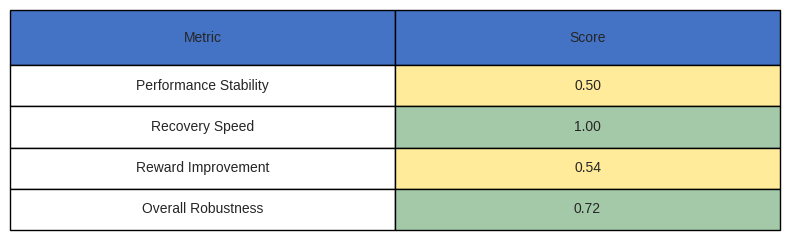

In [12]:
# Create a nicely formatted table of key robustness metrics
import pandas as pd
from IPython.display import display, HTML

# Assuming robustness_scores is already calculated from the previous cell
# Select the most important metrics using original names
key_metrics = {
    'Performance Stability': robustness_scores['Performance Stability'],
    'Recovery Speed': robustness_scores['Recovery Speed'],
    'Reward Improvement': robustness_scores['Reward Improvement'],  # Original name
    'Overall Robustness': robustness_scores['Overall Robustness']
}

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Metric': list(key_metrics.keys()),
    'Score': list(key_metrics.values())
})

# Style the DataFrame
styled_df = metrics_df.style.set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4472C4'), 
                                ('color', 'white'),
                                ('font-weight', 'bold'),
                                ('text-align', 'center'),
                                ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('text-align', 'center'),
                                ('border', '1px solid black')]},
    {'selector': 'caption', 'props': [('caption-side', 'top'),
                                    ('font-size', '16pt'),
                                    ('font-weight', 'bold')]}
]).format({'Score': '{:.2f}'}).hide(axis='index').set_caption('Key Robustness Metrics')

# Apply background color based on score values
def background_gradient(s, metric):
    if metric == 'Score':
        return ['background-color: #a3c9a8' if v >= 0.7 else
                'background-color: #ffeb99' if v >= 0.5 else
                'background-color: #ffb3b3' for v in s]
    return [''] * len(s)

styled_df = styled_df.apply(background_gradient, axis=0, subset=['Score'], metric='Score')

# Create figure and save/display
display(HTML("<h2>Adaptive Reward Function Robustness Analysis</h2>"))
display(styled_df)

# Create matplotlib version for saving
import matplotlib.pyplot as plt
from matplotlib.table import Table

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')
table = Table(ax, bbox=[0, 0, 1, 1])

# Add header
for col_idx, col_name in enumerate(['Metric', 'Score']):
    table.add_cell(0, col_idx, width=0.5, height=0.2, 
                   text=col_name, loc='center', 
                   edgecolor='black', facecolor='#4472C4')
    
# Add data rows
for row_idx, (_, row) in enumerate(metrics_df.iterrows()):
    # Set the background colors based on the score
    score = row['Score']
    if score >= 0.7:
        color = '#a3c9a8'  # Green for good
    elif score >= 0.5:
        color = '#ffeb99'  # Yellow for moderate
    else:
        color = '#ffb3b3'  # Red for poor

    # Add metric name
    table.add_cell(row_idx+1, 0, width=0.5, height=0.15, 
                   text=row['Metric'], loc='center', 
                   edgecolor='black', facecolor='white')
    
    # Add score with colored background
    table.add_cell(row_idx+1, 1, width=0.5, height=0.15, 
                   text=f"{row['Score']:.2f}", loc='center', 
                   edgecolor='black', facecolor=color)

ax.add_table(table)
plt.tight_layout()

# Save the table as an image
plt.savefig('robustness_metrics_table.png', dpi=300, bbox_inches='tight')

To quantify robustness through this experiment, we define 4 key metrics:

1. **Performance Stability**: Measures how well the system maintains performance during environmental changes.                             Calculated as the ratio of minimum performance to average performance after changes.

2. **Recovery Speed**: Quantifies how quickly the system returns to normal operation after a disturbance.                               Measured as the number of episodes required to reach 90% of pre-change performance.

3. **Reward Improvement**: Represents the percentage increase in reward values after function updates.                                 Values above 0.5 indicate positive improvement, while values below 0.5 indicate degradation.

4. **Overall Robustness**: A composite score combining all metrics with appropriate weights.                                         Provides a single value representing the system's resilience to environmental changes and ability to adapt.